In [ ]:
pip list | grep tensorflow-datasets

tensorflow-datasets           4.0.1


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir = '/content/drive/MyDrive/aiffel/data'
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/drive/MyDrive/aiffel/data/cifar10/3.0.2.incompleteY0UHVD/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/drive/MyDrive/aiffel/data/cifar10/3.0.2.incompleteY0UHVD/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /content/drive/MyDrive/aiffel/data/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


## Input Normalization

Data normalization은 데이터 범위를 원하는 범위로 제한함. 예를 들어 0-255의 픽셀 정보를 갖는 이미지 데이터를 255로 나누어 0-1.0 사이의 값을 가지게 하는 작업이다. 머신러닝에서 이를 하는 이유는 scale이 큰 feature에 대한 영향이 비대해지는 것을 방지하고, 딥러닝에서는 local optimum에 빠질 위험을 줄여 학습 속도를 향상시킨다.

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_info.features["label"].num_classes

10

In [ ]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

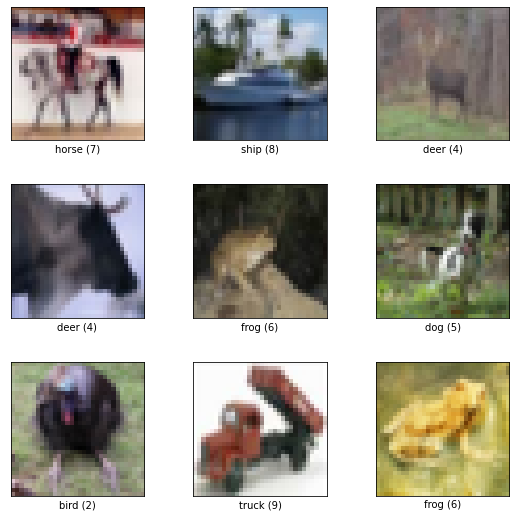

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

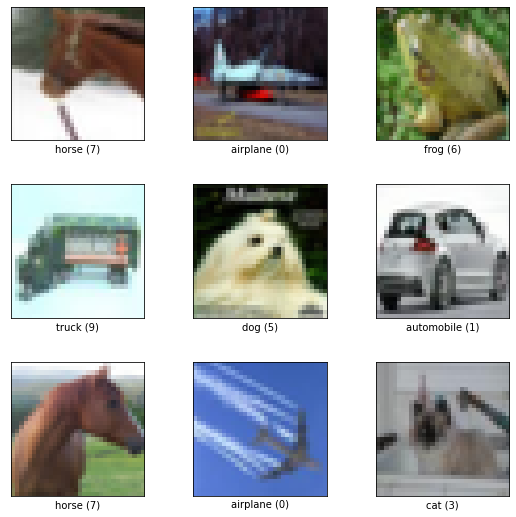

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

## Ablation Study
블록 구성하기

In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

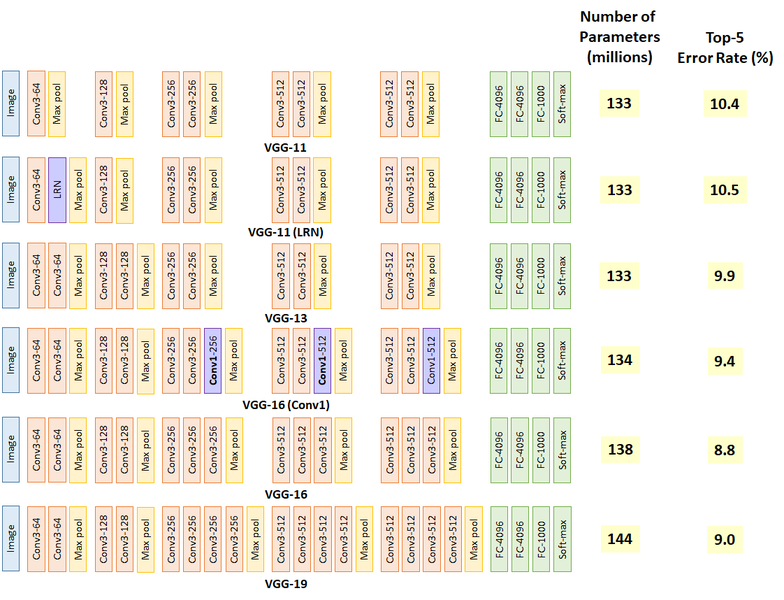

VGG - 16 과 VGG - 19 만들기

In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                             

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)


vgg_19.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

## VGG16 vs VGG19
두 모델의 성능 비교하기.

In [ ]:
BATCH_SIZE = 256
EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteI52ISG/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteI52ISG/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 45s 131ms/step - loss: 2.1834 - accuracy: 0.1899 - val_loss: 2.0792 - val_accuracy: 0.2192
Epoch 2/15
195/195 [==============================] - 23s 118ms/step - loss: 1.9848 - accuracy: 0.2794 - val_loss: 2.0089 - val_accuracy: 0.2898
Epoch 3/15
195/195 [==============================] - 24s 122ms/step - loss: 1.8468 - accuracy: 0.3374 - val_loss: 1.7992 - val_accuracy: 0.3602
Epoch 4/15
195/195 [==============================] - 24s 121ms/step - loss: 1.7383 - accuracy: 0.3755 - val_loss: 1.6680 - val_accuracy: 0.4186
Epoch 5/15
195/195 [==============================] - 24s 121ms/step - loss: 1.6569 - accuracy: 0.4030 - val_loss: 1.6292 - val_accuracy: 0.4283
Epoch 6/15
195/195 [==============================] - 24s 121ms/step - loss: 1.5903 - accuracy: 0.4274 - val_loss: 1.5402 - val_accuracy: 0.4539
Epoch 7/15
195/195 [==============================] - 24s 121ms/step - loss: 1.5312 - accuracy: 0.4508 - val_loss: 1.5042 - val_accuracy: 0.4

In [ ]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 32s 145ms/step - loss: 2.2151 - accuracy: 0.1713 - val_loss: 2.1208 - val_accuracy: 0.2148
Epoch 2/15
195/195 [==============================] - 28s 143ms/step - loss: 2.0432 - accuracy: 0.2505 - val_loss: 1.9760 - val_accuracy: 0.2936
Epoch 3/15
195/195 [==============================] - 28s 142ms/step - loss: 1.9176 - accuracy: 0.3029 - val_loss: 1.8256 - val_accuracy: 0.3502
Epoch 4/15
195/195 [==============================] - 28s 142ms/step - loss: 1.7953 - accuracy: 0.3516 - val_loss: 1.7022 - val_accuracy: 0.3836
Epoch 5/15
195/195 [==============================] - 28s 143ms/step - loss: 1.6938 - accuracy: 0.3858 - val_loss: 1.6137 - val_accuracy: 0.4242
Epoch 6/15
195/195 [==============================] - 28s 144ms/step - loss: 1.6295 - accuracy: 0.4124 - val_loss: 1.5976 - val_accuracy: 0.4317
Epoch 7/15
195/195 [==============================] - 28s 142ms/step - loss: 1.5653 - accuracy: 0.4347 - val_loss: 1.5081 - val_accuracy: 0.4

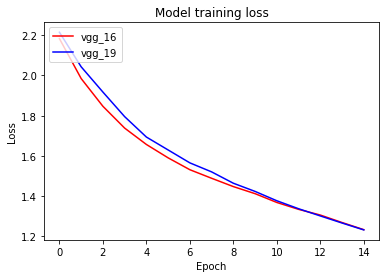

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

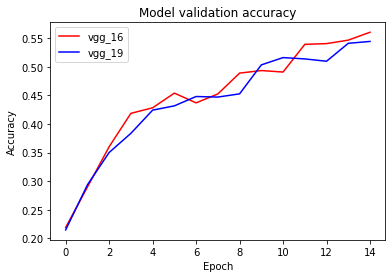

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

# GD(CV) Project : ResNet Ablation Study

|평가문항|상세기준|
|:---|:---|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

## 0) 라이브러리 버전 확인하기

In [2]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


## 1) ResNet 기본 블록 구성하기
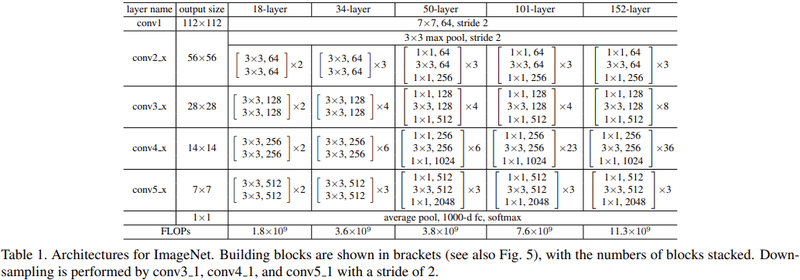

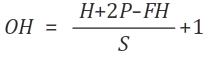

- 정사각형 이미지를 쓰기 때문에 OH = OW (각 Height, Width)
- P = Padding, FH = Filter Height, S = Stride를 의미한다.
- 논문에서 CIFAR-10의 32x32 이미지에 대해서는 맨 첫 convolution filter를 3x3으로 수정해서 쓴다. 그럴 경우 (32+2P-3)/2 +1 = 16.
- 차원만 맞추면 성립하기 때문에 방법은 여러가지. 위 예시처럼 할 수도 있고 Conv(2,2), stride = 2로 사용할 수도 있다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from keras.layers import ZeroPadding2D, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D, Input, Add
from keras import layers


In [2]:
# function for building ResNet Block
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection 
# 3x3 커널, 64채널 2층
# padding = 'same'은 output이 Math.ceil(input_size / stride)와 동일.

def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    is_50 = False,
                    # is_plain = False,
                   ):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
      for cnn_num in range(num_cnn):
          identity = x 
          # if channel == 64:
          #     x = Conv2D(
          #         filters=channel,
          #         kernel_size=(3,3),
          #         activation='relu',
          #         kernel_initializer='he_normal',
          #         padding='same',
          #         name=f'block{block_num}_conv{cnn_num}'
          #         )(x)
          # else:
          #     x = ZeroPadding2D(padding=(1,1))(x)
          #     x = Conv2D(
          #         filters=channel,
          #         kernel_size=(3,3),
          #         strides=(2,2),
          #         activation='relu',
          #         kernel_initializer='he_normal',
          #         padding='valid',
          #         name=f'block{block_num}_conv{cnn_num}',
          #         )(x)
          # if not is_plain:
          identity_channel = identity.shape.as_list()[-1]

          if identity_channel != channel:
                  x = ZeroPadding2D(padding=(1,1))(x)
                  x = Conv2D(
                      filters=channel,
                      kernel_size=(3,3),
                      strides=(2,2),
                      activation='relu',
                      kernel_initializer='he_normal',
                      padding='valid',
                      name=f'block{block_num}_conv{cnn_num}',
                      )(x)
                  x = BatchNormalization()(x)
                  x = Conv2D(
                      filters=channel,
                      kernel_size=(3,3),
                      activation='relu',
                      kernel_initializer='he_normal',
                      padding='same',
                      name=f'block{block_num}_1_conv{cnn_num}',
                  )(x)
                  x = Add()(x)

          else:
                  x = Conv2D(
                      filters=channel,
                      kernel_size=(3,3),
                      activation='relu',
                      kernel_initializer='he_normal',
                      padding='same',
                      name=f'block{block_num}_conv{cnn_num}'
                  )(x)
                  x = BatchNormalization()(x)
                  x = Conv2D(
                      filters=channel,
                      kernel_size=(3,3),
                      activation='relu',
                      kernel_initializer='he_normal',
                      padding='same',
                      name=f'block{block_num}_1_conv{cnn_num}',
                  )(x) 

                  identity = Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='same')(identity)
                  x = Add()([x,identity]) # ex) 64+64 = 128

          # if not is_plain:
          #     identity_channel = identity.shape.as_list()[-1] # ex) input : (3,3,64) 마지막이 채널 수를 나타내기 때문에.
          
              
                
          # else:
          #     pass


    else:
      identity = x
      x = Conv2D(
          filters=channel,
          kernel_size=(1,1),
          activation='relu',
          kernel_initializer='he_normal',
          padding='same',
          name=f'block{block_num}_conv{cnn_num}'
      )(x)
      x = BatchNormalization()(x)
      x = Conv2D(
          filters=channel,
          kernel_size=(3,3),
          activation='relu',
          kernel_initializer='he_normal',
          padding='same',
          name=f'block{block_num}_1_conv{cnn_num}'          
      )(x)
      x = BatchNormalization()(x)
      x = Conv2D(
          filters=channel*4,
          kernel_size=(1,1),
          activation='relu',
          kernel_initializer='he_normal',
          padding='same',
          name=f'block{block_num}_2_conv{cnn_num}',
      )(x)
      # if not is_plain:
      identity_channel = identity.shape.as_list()[-1] 
      
      if identity_channel != channel:
        identity = Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='same')(identity)
        x = Add()([x,identity])
        x = layers.Activation(activations.relu)(x)
      else:
        pass

    return x

- ResNet 34와 50은 3-4-6-3 순서의 동일한 블록 구조를 갖고 있다.
- 채널의 크기 또한 해당 층마다 64-128-256-512로 동일하나 50의 경우 마지막에 4배로 커졌다가 줄어든다.

In [3]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #num_cnn_list 와 channel_list의 짝이 맞는지 확인해주는 코드로서 추가.

    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = Input(shape=input_shape)  # input layer를 만들어둡니다.32
    output = input_layer
    #conv1층
    output = ZeroPadding2D(padding=(1,1))(output)#34
    output = Conv2D(filters=64,
                       kernel_size = (3,3),#31
                       strides = (2, 2),#15+1
                       padding = 'valid')(output)
    output = BatchNormalization()(output)
    
    #conv2_x pooling
    output = ZeroPadding2D(padding=(1,1))(output)
    output = MaxPooling2D(pool_size = (3,3),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
            )    
    output = GlobalAveragePooling2D()(output)
    output = Flatten(name='flatten')(output)
    output = Dense(1000, activation='relu', name='fc1')(output) # 선택사항으로 생각함. 바로 Dense10일 경우 
    output = Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [4]:
resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

In [5]:
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 34, 34, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   1792        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [27]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [24]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [25]:
resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

In [26]:
resnet_34.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_72 (Conv2D)             (None, 16, 16, 64)   832         ['input_20[0][0]']               
                                                                                                  
 batch_normalization_299 (Batch  (None, 16, 16, 64)  256         ['conv2d_72[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_19 (MaxPooling2D  (None, 8, 8, 64)    0           ['batch_normalization_299[

## 2) ResNet-34, ResNet-50 Complete Model

## 3) 일반 네트워크(plain network) 만들기

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34